<a href="https://colab.research.google.com/github/GwiHwan-Go/Reproduce_CutMix/blob/main/Training/CutMix_baseline_tinyImagenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip -q tiny-imagenet-200.zip && ls tiny-imagenet-200

--2022-05-18 17:21:18--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  5.75MB/s    in 57s     

2022-05-18 17:22:21 (4.12 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]

test  train  val  wnids.txt  words.txt


In [1]:
import json
import os
import torch


In [30]:

from torchvision.transforms import ToTensor
import torchvision.transforms as transforms

from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data.dataloader import *
import cv2 # OpenCV


In [ ]:
with open('./tiny-imagenet-200/wnids.txt', 'r') as f :
  label_id = f.readlines()
label_id = [i[:-1] for i in label_id]
len(label_id)

In [31]:
def parseClasses(file):
    classes = []
    filenames = []
    with open(file) as f:
        lines = f.readlines()
    lines = [x.strip() for x in lines]
    for x in range(0,len(lines)):
        tokens = lines[x].split()
        classes.append(tokens[1])
        filenames.append(tokens[0])
    return filenames,classes
    
class TImgNetDataset(Dataset):
    """Dataset wrapping images and ground truths."""
    
    def __init__(self, img_path, gt_path, class_to_idx=None, transform=None):
        self.img_path = img_path
        self.transform = transform
        self.gt_path = gt_path
        self.class_to_idx = class_to_idx
        self.classidx = []
        self.imgs, self.classnames = parseClasses(gt_path)
        for classname in self.classnames:
            self.classidx.append(self.class_to_idx[classname])

    def __getitem__(self, index):
            """
            Args:
                index (int): Index
            Returns:
                tuple: (image, y) where y is the label of the image.
            """
            img = None
            with open(os.path.join(self.img_path, self.imgs[index]), 'rb') as f:
                img = Image.open(f)
                img = img.convert('RGB')
                if self.transform is not None:
                    img = self.transform(img)
            y = self.classidx[index]
            return img, y

    def __len__(self):
        return len(self.imgs)

In [38]:
batch_size = 256
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

train_transform = transforms.Compose([
            transforms.Resize(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,

        ])
test_transform = transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor(),
            normalize,

        ])

In [57]:
import torchvision.datasets as datasets

train_set = datasets.ImageFolder("./tiny-imagenet-200/train", transform=train_transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

val_set = TImgNetDataset("./tiny-imagenet-200/val/images", "./tiny-imagenet-200/val/val_annotations.txt", class_to_idx=train_loader.dataset.class_to_idx.copy(),
            transform=test_transform)
valid_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

test_set = datasets.ImageFolder("./tiny-imagenet-200/test", transform=test_transform)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


class labels: tensor([166, 136,  50, 182, 193,   3, 124, 161, 105,  32, 129,  36, 157,  22,
        187, 151,  17,  20,  24, 122, 102,  18, 163,  28, 145,   9,  62,  34,
        113,   6, 147, 145, 151, 192,  45, 108, 108,  83,  49, 136, 177,  37,
         43,  63, 168, 148,  26,  20, 147, 104,  23,  15,  57,  60, 106, 143,
         64, 107, 186, 114, 118,  42,  70, 122, 147, 159, 175, 106, 140,  63,
         78,  12, 124, 170, 154, 175, 156, 187,  23,  90,  11,  35, 128,  87,
        176, 152, 174,  76,  17,  36, 141,  34,  63,  62,  28, 154, 199,  10,
         70, 104, 140,  56, 149,   6, 137,  55,  96,   2, 176, 106, 134,  99,
         44,  84,  54,  41,  33, 182, 131,  25, 126,  79,  67,  39,  51, 138,
         53,  57, 187,   6,  59,  95, 189, 192, 157,  92, 150,  38, 150, 177,
         66, 119,  40, 198, 186,  18, 129, 197, 185, 107,  15, 153, 129, 168,
        173,  42, 115,  14, 128,  87, 171, 170, 158, 133,  66,  71,   9, 100,
        138,  67,  63, 156,   3,  65, 175,  42,  5

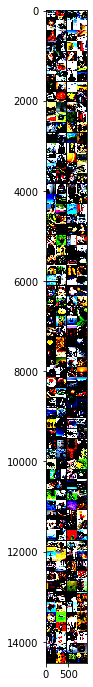

In [41]:
import matplotlib.pyplot as plt
import torchvision

batch = next(iter(train_loader))
images, labels = batch

plt.figure(figsize=(12,12))
grid = torchvision.utils.make_grid(tensor=images, nrow=4) # nrow = number of images displayed in each row

print(f"class labels: {labels}")

# Use grid.permute() to transpose the grid so that the axes meet the specifications required by 
# plt.imshow(), which are [height, width, channels]. PyTorch dimensions are [channels, height, width].
plt.imshow(grid.permute(1,2,0))

In [42]:
import numpy as np

def cut(W,H,lam):
        
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int64(W * cut_rat)
    cut_h = np.int64(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

In [62]:
images, labels = next(iter(valid_loader))
rand_index = torch.randperm(images.shape[0])
shuffled_images = images[rand_index]
lam = np.random.beta(1.0, 1.0)
cutmix_images = images.clone().detach()
cutout_images = images.clone().detach() 
mixup_images = images.clone().detach() 

bbx1, bby1, bbx2, bby2 = cut(images.shape[2], images.shape[3], lam) # define a box to cut and mix

In [63]:
## CUTMIX ##
cutmix_images[:, :, bbx1:bbx2, bby1:bby2] = cutmix_images[rand_index, :, bbx1:bbx2, bby1:bby2]
## CUTOUT ##
cutout_images[:, :, bbx1:bbx2, bby1:bby2] = 0.
## MIXUP ##
mixup_images = lam * mixup_images + (1 - lam) * mixup_images[rand_index,:,:]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


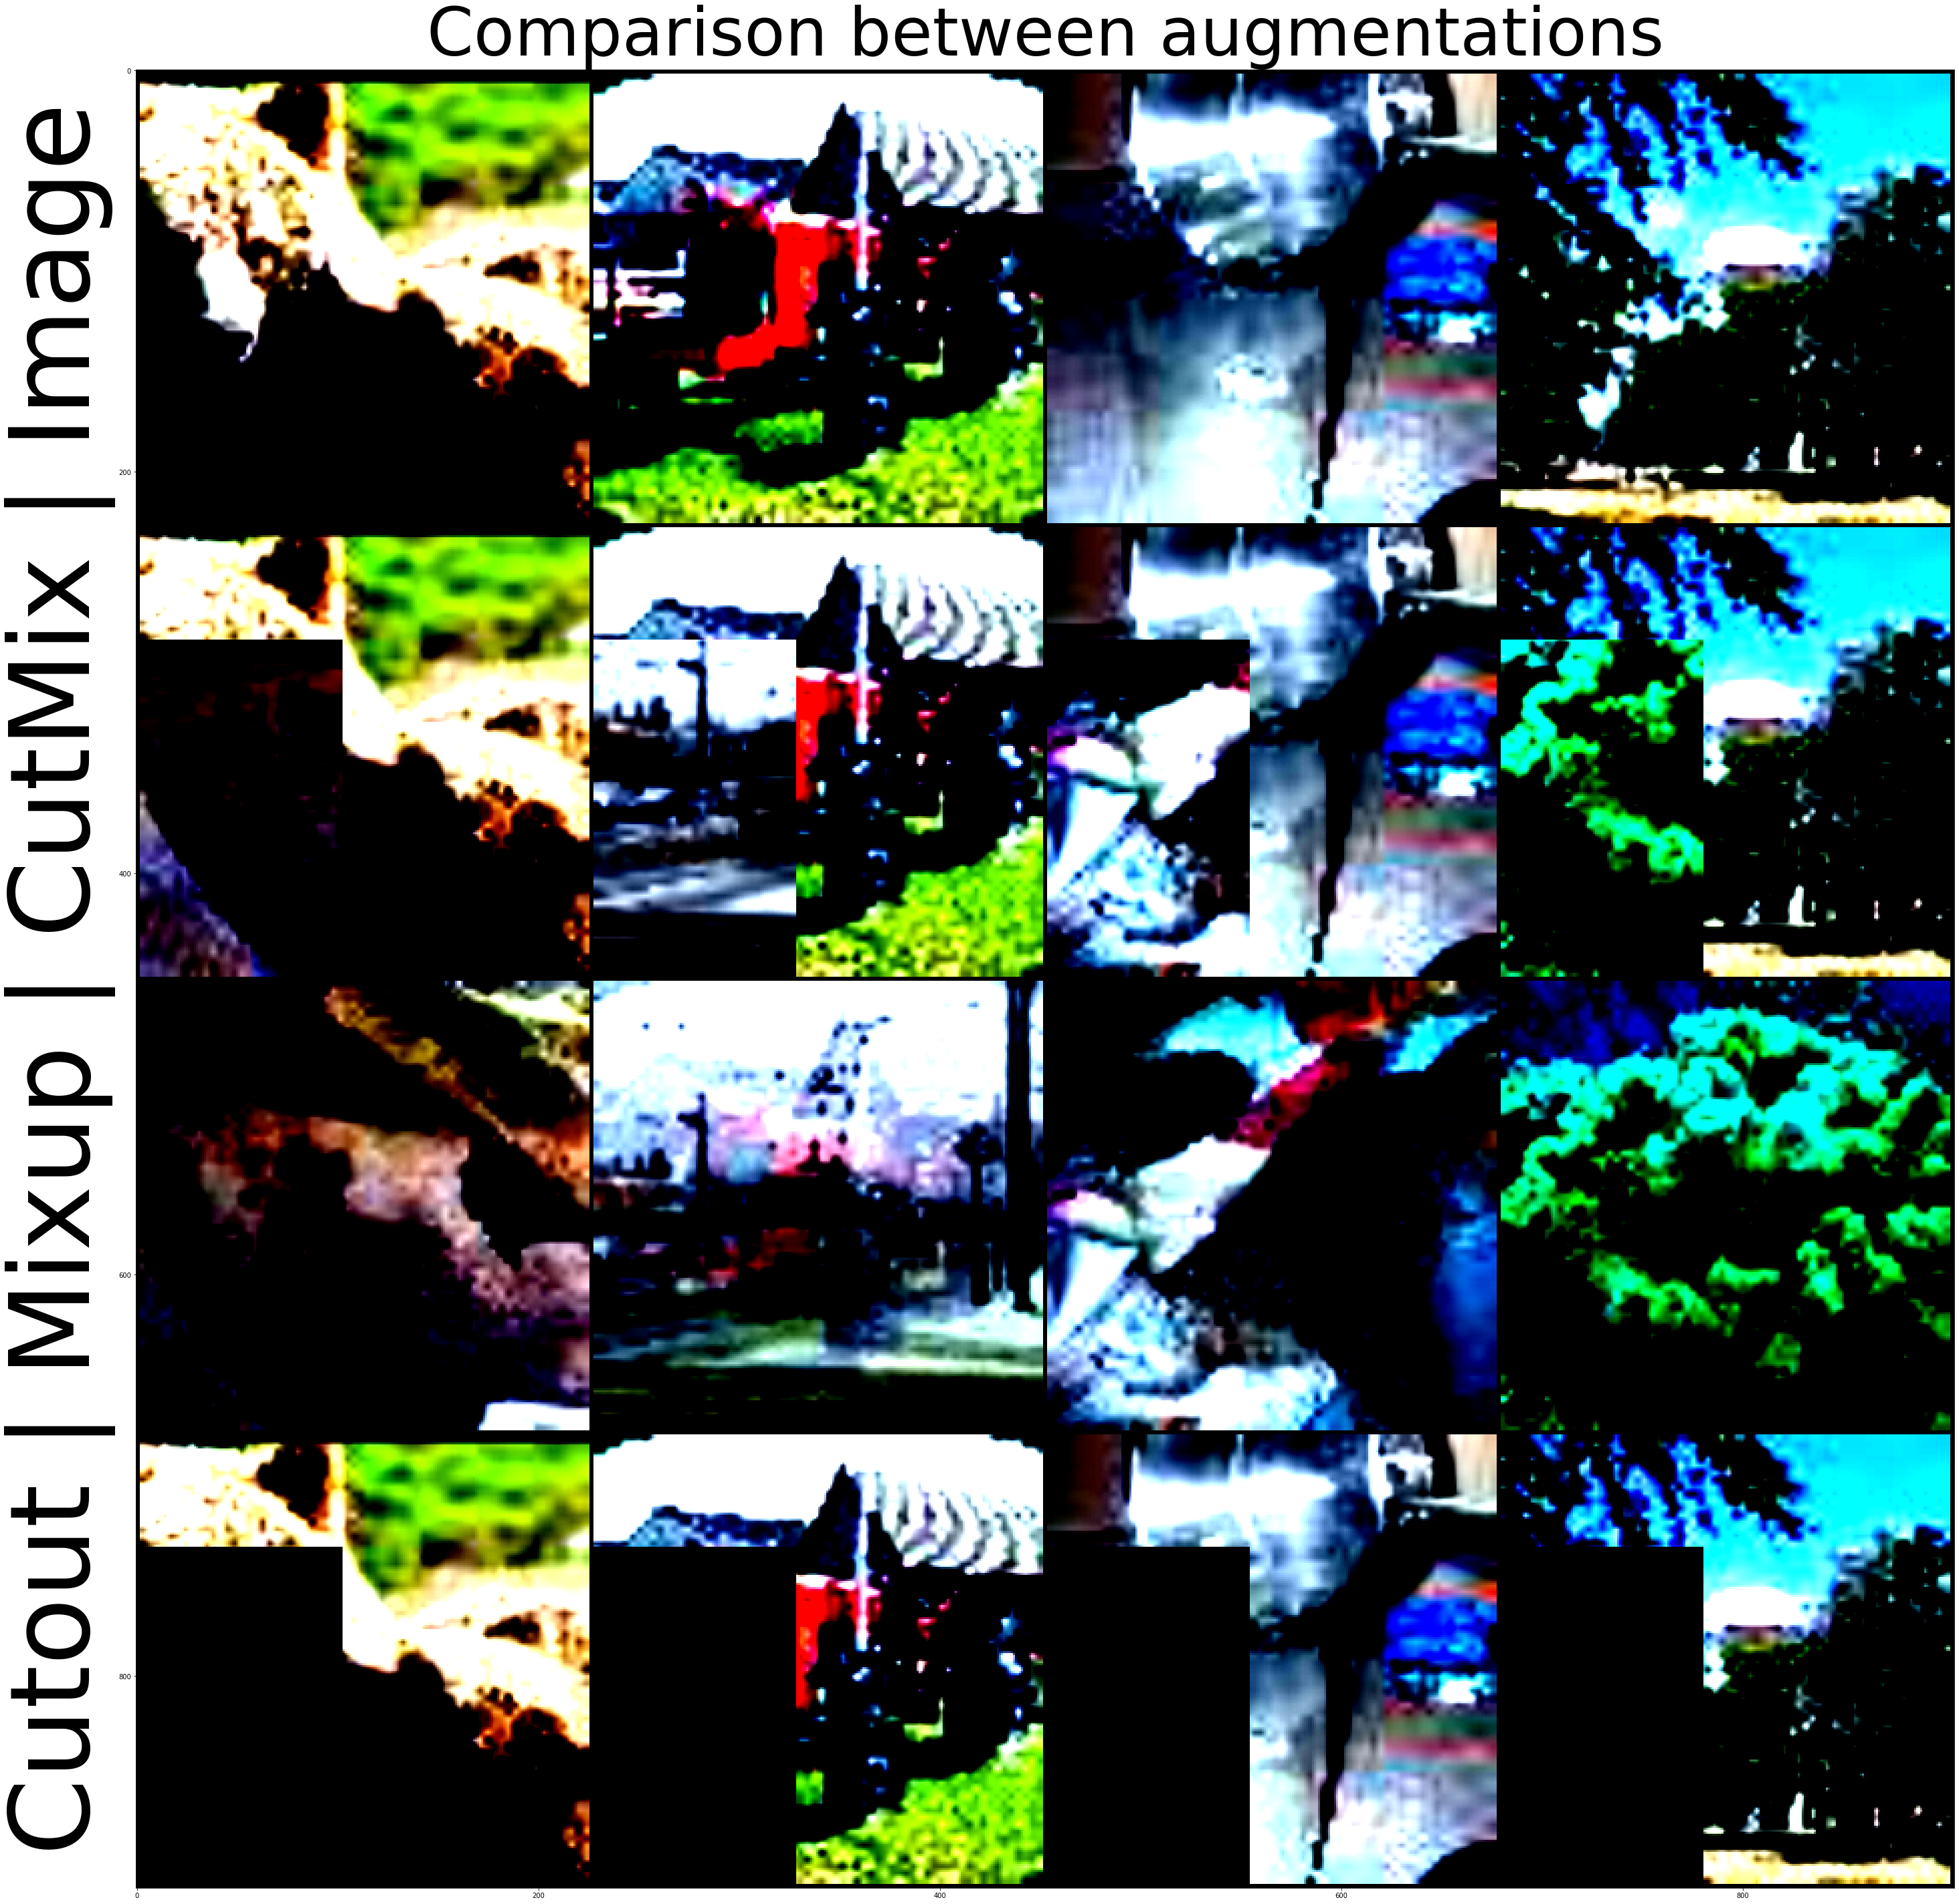

In [64]:
  
def show_cutMixed_compare(row1, row2, row3, row4, nums_show):
    rand_index = torch.randperm(row1.size()[0])[:nums_show]
    to_compare = torch.cat([row1[rand_index,:,:],row2[rand_index,:,:],row3[rand_index,:,:],row4[rand_index,:,:]],dim=0)
    plt.figure(figsize=(50,50))
    grid = torchvision.utils.make_grid(tensor=to_compare, nrow=nums_show)
    plt.ylabel("Cutout | Mixup | CutMix | Image",fontsize=165, rotation = 90)
    plt.title("Comparison between augmentations", fontsize=100)
    plt.imshow(grid.permute(1,2,0))

show_cutMixed_compare(images, cutmix_images, mixup_images, cutout_images, 4)

In [49]:
from torch.nn import Linear
from torchvision import models

# resnet50 Model Loading
use_pretrained = False
model = models.resnet50(pretrained=use_pretrained)
## 우리 이미지 사이즈에 맞게 튜닝

model.fc = torch.nn.Linear(2048, len(labels)) 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# model = model.to(device)

cuda


In [72]:
import torch.optim as optim
import torch.nn as nn
from tqdm.auto import tqdm, trange

    
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].contiguous().view(-1).float().sum(0, keepdim=True)
        wrong_k = batch_size - correct_k
        res.append(wrong_k.mul_(100.0 / batch_size))
    return res
    
def train_model(model, 
                train, 
                valid,
                resume = None,
                n_iters=300, 
                learn_rate=0.1, 
                weight_decay=0, 
                which_method=0
                ):  # Lists to store model's performance information
  po = 0
  top1_errs, top5_errs, train_losses = [], [], []
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=learn_rate, momentum=0.9, weight_decay=weight_decay)

###############Checkpoint Zone################
  if resume is not None :
    checkpoint = torch.load(resume) 
    model.load_state_dict(checkpoint['model_state_dict'])
    loss = checkpoint['loss']
    num_epochs = checkpoint['total_epochs'] - checkpoint['epoch']
    top1_errs = checkpoint['top1_err']
    top5_errs = checkpoint['top5_err']
  else :
    num_epochs = n_iters
###############Checkpoint Zone###############
  
  print(f"We still have to go {num_epochs} epochs" )
  for i in trange(num_epochs):

    ##############################learning_decay#####################################
    if (num_epochs-i) < 75 :
      newpo = 3
    elif (num_epochs-i) < 150 :
      newpo = 2
    elif (num_epochs-i) < 225 :
      newpo = 1
    else :
      newpo = 0
    if po != newpo :
      po = newpo
      lr = learn_rate * (0.1 ** po) ##learning_decay
      print(f"lr has decayed to {lr}")
      optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
    ##############################learning_decay#####################################

    try :
      for images, labels in tqdm(train) :

        images, labels = images.to(device), labels.to(device)
        model = model.to(device)
        model.train() # For Dropout and Batch Norm layers #

        if which_method and (np.random.rand()<0.5) :

          lam = np.random.beta(1.0, 1.0)
          rand_index = torch.randperm(images.size()[0])
          shuffled_labels = labels[rand_index]

          ##############Do Something On Data###############
          if which_method == 1 : ##cutmix
            bbx1, bby1, bbx2, bby2 = cut(images.shape[2], images.shape[3], lam) # define a box to cut and mix
            images[:, :, bbx1:bbx2, bby1:bby2] = images[rand_index, :, bbx1:bbx2, bby1:bby2] #cut and mix
            lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (images.shape[-1] * images.shape[-2]))
          if which_method == 2 : ##mixup
            images = lam * images + (1 - lam) * images[rand_index,:,:]
          if which_method == 3 : ##cutout
            bbx1, bby1, bbx2, bby2 = cut(images.shape[2], images.shape[3], lam) # define a box to cut and mix
            images[:, :, bbx1:bbx2, bby1:bby2] = 0.
          ##############Do Something On Data###############

          #############Forward Pass##############
          out = model(images) 
          #############Forward Pass##############

          ##############Modify Loss Function###############
          if which_method == 1 : ##cutmix
            loss = criterion(out, labels) * lam + criterion(out, shuffled_labels)*(1.0-lam) # compute the total loss
          if which_method == 2 : ##mixup
            loss = criterion(out, labels) * lam + criterion(out, shuffled_labels)*(1.0-lam)
          if which_method == 3 : ##cutout
            loss = criterion(out, labels)
          ##############Modify Loss Function###############

        else : ## if random.rand > 0.5 or which_method == 0
          
          out = model(images)
          loss = criterion(out, labels)

        loss.backward()               # backward pass (compute parameter updates)
        optimizer.step()              # make the updates for each parameter
        optimizer.zero_grad()         # reset the gradients for the next iteration
      
      #####################model Evaluation#############
      print(loss.item())
      model.eval()
      sum_top1, sum_top5 = 0,0
      for images, labels in valid :
        print('is here?')
        images,labels = images.to(device), labels.to(device)
        

        output = model(images)
        
        top1, top5 = accuracy(output, labels, topk=(1,5))
        print('is here3?')
        sum_top1+=top1.item()
        sum_top5+=top5.item()
      
      size = len(valid)
      #####################model Evaluation#############

      ###################save history#####################
      train_losses.append(loss.item())
      top1_errs.append(sum_top1/size)
      top5_errs.append(sum_top5/size)
      ###################save history#####################

      if (i+1) % 10 == 0 :

        PATH=f"./{300-(num_epochs-i)}th_checkpoint.pt"
        torch.save({'total_epochs':num_epochs, 'epoch': i, 'model_state_dict': model.state_dict(), 
        'optimizer_state_dict': optimizer.state_dict(), 'loss': loss, 'top1_err': top1_errs, 'top5_err': top5_errs, 'train_loss':train_losses }, PATH)
        print(f"Successfully saved untill {i} step in {PATH} with model, optimizer, and loss.")

    except :
      PATH=f"./{300-(num_epochs-i)}th_checkpoint.pt"
      torch.save({'total_epochs':num_epochs, 'epoch': i, 'model_state_dict': model.state_dict(), 
      'optimizer_state_dict': optimizer.state_dict(), 'loss': loss, 'top1_err': top1_errs, 'top5_err': top5_errs , 'train_loss':train_losses}, PATH)
      print(f"Successfully saved untill {i} step in {PATH} with model, optimizer, and loss.")
      return [top1_errs,top5_errs]

  PATH = "./trained.pt"
  print("train finished")
  print(f"Successfully saved untill {n_iters} step in {PATH} with model, optimizer, and loss.")
  torch.save({'total_epochs':num_epochs, 'epoch': i, 'model_state_dict': model.state_dict(), 
  'optimizer_state_dict': optimizer.state_dict(), 'loss': loss, 'top1_err': top1_errs, 'top5_err': top5_errs, 'train_loss':train_losses}, PATH)
  return [top1_errs,top5_errs]


In [75]:
##You should run this cell ONLY FIRST TIME!!!
##Otherwise It will OverWrite your Checkpoint file.

logs = train_model(model, valid_loader, test_loader, n_iters=300, 
                    learn_rate=0.1, 
                    weight_decay=0, which_method=1) 

#which method 
# 0: nothing, 
# 1: cutmix, 
# 2: mixup 
# 3: cutout

We still have to go 300 epochs


UnboundLocalError: local variable 'loss' referenced before assignment

In [61]:
checkpoint = torch.load("./0th_checkpoint.pt")
checkpoint['train_loss']

[]

In [ ]:
## Chek point load 요령 ##
PATH="_" ## Where checkpoint saved. ## saved checkpoint

train_model(model,
            train_loader, 
            valid_loader,
            n_iters=300, 
            learn_rate=0.1, 
            resume=PATH,
            weight_decay=0, 
            which_method=1) 

Successfully saved untill 0 step in ./checkpoint.pt with model, optimizer, and loss.


[]

## Evaluate

In [ ]:
## If train was succeed, let's evaluate it.

In [ ]:
PATH="./trained.pt"
checkpoint = torch.load(PATH) 
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
sum_top1, sum_top5 = 0,0

for images, labels in valid_loader :
    images,labels = images.to(device), labels.to(device)
    output = model(images)
    top1, top5 = accuracy(output, labels, topk=(1,5))
    sum_top1+=top1.item()
    sum_top5+=top5.item()

size = len(valid_loader)

print(sum_top1/size, sum_top5/size)

NameError: name 'torch' is not defined

In [ ]:
checkpoint['top1_err']

[39.275, 38.73]

https://github.com/facebookresearch/mixup-cifar10/blob/main/train.py